###### import posenet

In [45]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
parser.add_argument('--model', type=int, default=101)
parser.add_argument('--cam_id', type=int, default=0)
parser.add_argument('--cam_width', type=int, default=1280)
parser.add_argument('--cam_height', type=int, default=720)
parser.add_argument('--scale_factor', type=float, default=0.7125)
parser.add_argument('--file', type=str, default=None, help="Optionally use a video file instead of a live camera")
args = parser.parse_args()

NameError: name 'parser' is not defined

In [5]:
with tf.Session() as sess:
        model_cfg, model_outputs = posenet.load_model(101, sess)
        output_stride = model_cfg['output_stride']

        cap = cv2.VideoCapture(video_file_path)
        cap.set(3, 1280)
        cap.set(4, 720)

        start = time.time()
        dfs=[]
    
        #fixed_pose_id limits the readout of coords to one person
        fixed_pose_id=0
        
        while True:
            input_image, display_image, output_scale = posenet.read_cap(
                cap, scale_factor=0.7125, output_stride=output_stride)

            heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = sess.run(
                model_outputs,
                feed_dict={'image:0': input_image}
            )

            pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multi.decode_multiple_poses(
                heatmaps_result.squeeze(axis=0),
                offsets_result.squeeze(axis=0),
                displacement_fwd_result.squeeze(axis=0),
                displacement_bwd_result.squeeze(axis=0),
                output_stride=output_stride,
                max_pose_detections=10,
                min_pose_score=0.15)
            
            keypoint_coords *= output_scale

NameError: name 'tf' is not defined

In [152]:
df=pd.read_csv('kp_coords/grundhaltung.csv')
data=pd.read_csv('kp_coords/grundhaltung.csv')

df.loc[df['keypoint_score']<0.10,['x','y']] = np.nan

In [153]:
df_nose = (df.loc[df['part_names'] == 'nose', ['frame_count', 'x', 'y']].copy())
df_nose.columns = ['frame_count', 'x_nose', 'y_nose']
df = df.merge(df_nose, how='left', on='frame_count')
df['x'] -= df['x_nose']
df['y'] -= df['y_nose']
df = df.drop(['x_nose','y_nose'], axis=1)
df.rename(columns={"x": "x_dist_to_nose", "y": "y_dist_to_nose"},inplace=True)



In [154]:
df[df['part_names']=='leftEye']

,frame_count,pose_score,part_names,keypoint_score,x_dist_to_nose,y_dist_to_nose,timestamp
1,0,0.551949,leftEye,0.999013,22.926975,-20.119409,0
18,1,0.527775,leftEye,0.998816,23.384023,-21.244338,0
35,2,0.536190,leftEye,0.987827,23.652792,-19.171601,0
52,3,0.520792,leftEye,0.988244,24.639850,-20.484418,0
69,4,0.533132,leftEye,0.991362,24.697821,-19.242655,0
...,...,...,...,...,...,...,...
2058,121,0.000000,leftEye,0.000000,NaN,NaN,7
2075,122,0.000000,leftEye,0.000000,NaN,NaN,7
2092,123,0.227346,leftEye,0.997405,60.418685,-74.970612,7
2109,124,0.220589,leftEye,0.999230,58.442572,-78.996425,7


In [155]:
df_prev=df.copy()
df_prev['frame_count']=df_prev['frame_count']+1
df_prev=df_prev.drop(['pose_score','keypoint_score'],axis=1)
df_prev.rename(columns={"x_dist_to_nose": "x_dist_to_nose_in_prev_frame", "y_dist_to_nose": "y_dist_to_nose_in_prev_frame"},inplace=True)
df_prev=df.merge(df_prev, on=['frame_count','part_names'])
df_prev['x_movement']=df_prev['x_dist_to_nose']-df_prev['x_dist_to_nose_in_prev_frame']
df_prev['y_movement']=df_prev['y_dist_to_nose']-df_prev['y_dist_to_nose_in_prev_frame']
df_prev['movement_vector_length']=((df_prev['x_movement']**2)+(df_prev['y_movement']**2))**(1/2)

In [156]:
df_prev['part_names'].unique()

array(['nose', 'leftEye', 'rightEye', 'leftEar', 'rightEar',
       'leftShoulder', 'rightShoulder', 'leftElbow', 'rightElbow',
       'leftWrist', 'rightWrist', 'leftHip', 'rightHip', 'leftKnee',
       'rightKnee', 'leftAnkle', 'rightAnkle'], dtype=object)

In [157]:
df_prev.tail(20)

,frame_count,pose_score,part_names,keypoint_score,x_dist_to_nose,y_dist_to_nose,timestamp_x,x_dist_to_nose_in_prev_frame,y_dist_to_nose_in_prev_frame,timestamp_y,x_movement,y_movement,movement_vector_length
2105,124,0.220589,rightKnee,0.000583,NaN,NaN,7,NaN,NaN,7,NaN,NaN,NaN
2106,124,0.220589,leftAnkle,0.000659,NaN,NaN,7,NaN,NaN,7,NaN,NaN,NaN
2107,124,0.220589,rightAnkle,0.000880,NaN,NaN,7,NaN,NaN,7,NaN,NaN,NaN
2108,125,0.236733,nose,0.526702,0.000000,0.000000,7,0.000000,0.000000,7,0.000000,0.000000,0.000000
2109,125,0.236733,leftEye,0.998671,59.548888,-74.375857,7,58.442572,-78.996425,7,1.106316,4.620567,4.751166
2110,125,0.236733,rightEye,0.852136,-69.127813,-61.503137,7,-67.516320,-69.144955,7,-1.611493,7.641818,7.809885
2111,125,0.236733,leftEar,0.872709,132.149303,-46.206105,7,128.296998,-60.987620,7,3.852305,14.781515,15.275256
2112,125,0.236733,rightEar,0.625613,-129.392621,-35.180181,7,-123.068992,-32.397601,7,-6.323629,-2.782580,6.908765
2113,125,0.236733,leftShoulder,0.005036,NaN,NaN,7,NaN,NaN,7,NaN,NaN,NaN
2114,125,0.236733,rightShoulder,0.114469,-184.562654,274.097994,7,NaN,NaN,7,NaN,NaN,NaN


In [158]:
total_movement= np.sum(df_prev['movement_vector_length'])
list=[]
for bodypart in df_prev['part_names'].unique():
     list.append([bodypart,round(np.sum(df_prev[df_prev['part_names']==bodypart]['movement_vector_length'])/total_movement,2)])

In [159]:
list

[['nose', 0.0],
 ['leftEye', 0.03],
 ['rightEye', 0.04],
 ['leftEar', 0.04],
 ['rightEar', 0.05],
 ['leftShoulder', 0.07],
 ['rightShoulder', 0.05],
 ['leftElbow', 0.07],
 ['rightElbow', 0.11],
 ['leftWrist', 0.13],
 ['rightWrist', 0.13],
 ['leftHip', 0.14],
 ['rightHip', 0.14],
 ['leftKnee', 0.0],
 ['rightKnee', 0.0],
 ['leftAnkle', 0.0],
 ['rightAnkle', 0.0]]

In [160]:
df_prev

,frame_count,pose_score,part_names,keypoint_score,x_dist_to_nose,y_dist_to_nose,timestamp_x,x_dist_to_nose_in_prev_frame,y_dist_to_nose_in_prev_frame,timestamp_y,x_movement,y_movement,movement_vector_length
0,1,0.527775,nose,0.998889,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.000000
1,1,0.527775,leftEye,0.998816,23.384023,-21.244338,0,22.926975,-20.119409,0,0.457048,-1.124929,1.214232
2,1,0.527775,rightEye,0.998106,-24.563407,-17.121879,0,-24.858237,-17.169467,0,0.294830,0.047588,0.298646
3,1,0.527775,leftEar,0.972695,58.672707,7.885146,0,57.052647,8.935212,0,1.620060,-1.050066,1.930605
4,1,0.527775,rightEar,0.968338,-47.676923,9.818184,0,-48.828373,12.141215,0,1.151450,-2.323031,2.592742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120,125,0.236733,rightHip,0.006874,NaN,NaN,7,NaN,NaN,7,NaN,NaN,NaN
2121,125,0.236733,leftKnee,0.001075,NaN,NaN,7,NaN,NaN,7,NaN,NaN,NaN
2122,125,0.236733,rightKnee,0.000513,NaN,NaN,7,NaN,NaN,7,NaN,NaN,NaN
2123,125,0.236733,leftAnkle,0.000933,NaN,NaN,7,NaN,NaN,7,NaN,NaN,NaN


In [161]:
df_prev['x_movement']=df_prev['x_dist_to_nose']-df_prev['x_dist_to_nose_in_prev_frame']
df_prev['y_movement']=df_prev['y_dist_to_nose']-df_prev['y_dist_to_nose_in_prev_frame']

In [162]:
#number of nans:
df_prev[df_prev['part_names']=='rightWrist']['movement_vector_length'].isna().sum()

45

In [163]:
#in this table:
df_prev[df_prev['part_names']=='rightWrist']['movement_vector_length']

10      5.345670
27      6.365260
44      1.968806
61      1.584607
78      3.376743
          ...   
2050         NaN
2067         NaN
2084         NaN
2101         NaN
2118         NaN
Name: movement_vector_length, Length: 125, dtype: float64

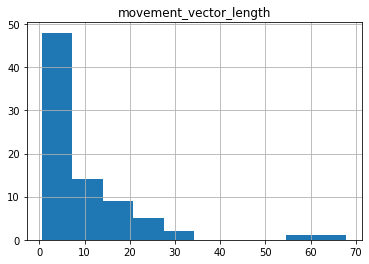

In [164]:
df_prev[df_prev['part_names']=='rightWrist'].hist(column='movement_vector_length')
plt.show()

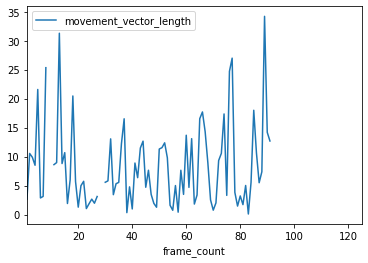

In [165]:
df_prev[df_prev['part_names']=='leftWrist'].plot(x='frame_count', y='movement_vector_length')
plt.savefig('abrupt.png')

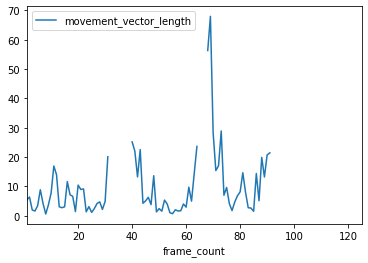

In [166]:
df_prev[df_prev['part_names']=='rightWrist'].plot(x='frame_count', y='movement_vector_length')

In [169]:
leftwrist=df_prev[df_prev['part_names']=='leftWrist']
leftwrist=leftwrist.set_index('frame_count')
leftwrist=leftwrist['movement_vector_length']
leftwrist=leftwrist.rename(columns={"'movement_vector_length'": "a"})

In [170]:
rightwrist=df_prev[df_prev['part_names']=='rightWrist']
rightwrist=rightwrist.set_index('frame_count')
rightwrist=rightwrist['movement_vector_length']
rightwrist=rightwrist.rename(columns={'movement_vector_length': 'eta'})
rightwrist

frame_count
1      5.345670
2      6.365260
3      1.968806
4      1.584607
5      3.376743
         ...   
121         NaN
122         NaN
123         NaN
124         NaN
125         NaN
Length: 125, dtype: float64

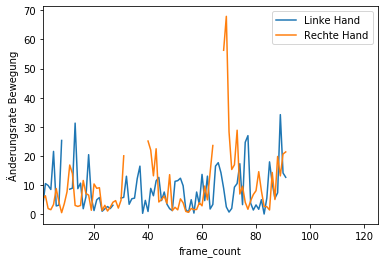

In [182]:
ax = leftwrist.plot(legend=True,label="Linke Hand")
ax.set_ylabel('Änderungsrate Bewegung')
rightwrist.plot(ax=ax, legend=True,label="Rechte Hand")
plt.savefig('grundhaltung.png')

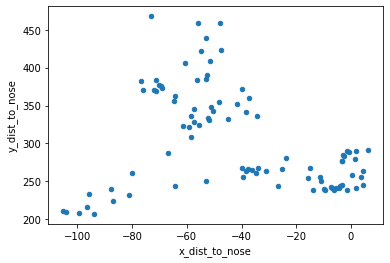

In [135]:
df_prev[df_prev['part_names']=='rightWrist'].plot.scatter(x='x_dist_to_nose',y='y_dist_to_nose')

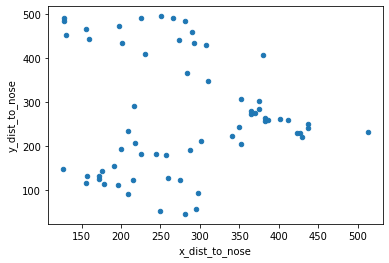

In [91]:
df_prev[df_prev['part_names']=='leftWrist'].plot.scatter(x='x_dist_to_nose',y='y_dist_to_nose')

In [46]:
data.part_names.unique()

array(['nose', 'leftEye', 'rightEye', 'leftEar', 'rightEar',
       'leftShoulder', 'rightShoulder', 'leftElbow', 'rightElbow',
       'leftWrist', 'rightWrist', 'leftHip', 'rightHip', 'leftKnee',
       'rightKnee', 'leftAnkle', 'rightAnkle'], dtype=object)

In [42]:
lW=data[data['part_names']=='leftWrist']
lW

,frame_count,pose_score,part_names,keypoint_score,x,y
9,0,0.000000,leftWrist,0.000000,0.000000,0.000000
26,1,0.000000,leftWrist,0.000000,0.000000,0.000000
43,2,0.000000,leftWrist,0.000000,0.000000,0.000000
60,3,0.000000,leftWrist,0.000000,0.000000,0.000000
77,4,0.000000,leftWrist,0.000000,0.000000,0.000000
94,5,0.000000,leftWrist,0.000000,0.000000,0.000000
111,6,0.000000,leftWrist,0.000000,0.000000,0.000000
128,7,0.000000,leftWrist,0.000000,0.000000,0.000000
145,8,0.000000,leftWrist,0.000000,0.000000,0.000000
162,9,0.000000,leftWrist,0.000000,0.000000,0.000000


In [44]:
visibility_rate=len(lW[lW['keypoint_score']!=0])/len(lW)

In [28]:
if 0==0:
    txt="a"
else:
    txt="b"

In [104]:
data[]

,frame_count,pose_score,part_names,keypoint_score,x,y
0,0,0.000000,nose,0.000000,0.000000,0.000000
1,0,0.000000,leftEye,0.000000,0.000000,0.000000
2,0,0.000000,rightEye,0.000000,0.000000,0.000000
3,0,0.000000,leftEar,0.000000,0.000000,0.000000
4,0,0.000000,rightEar,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
335,19,0.201788,rightHip,0.000909,503.210901,727.661975
336,19,0.201788,leftKnee,0.000246,1014.651526,704.086719
337,19,0.201788,rightKnee,0.001350,485.161085,703.653550
338,19,0.201788,leftAnkle,0.000760,1006.323770,717.569833


In [50]:
for part in data.part_names.unique():
    df=data[data['part_names']==part]
    visibility_rate=(len(df[df['keypoint_score']>0.1])/len(df))*100
    print("Your {} was visible in {} % of all frames".format(part,visibility_rate))

Your nose was visible in 35.0 % of all frames
Your leftEye was visible in 40.0 % of all frames
Your rightEye was visible in 40.0 % of all frames
Your leftEar was visible in 40.0 % of all frames
Your rightEar was visible in 30.0 % of all frames
Your leftShoulder was visible in 5.0 % of all frames
Your rightShoulder was visible in 20.0 % of all frames
Your leftElbow was visible in 0.0 % of all frames
Your rightElbow was visible in 0.0 % of all frames
Your leftWrist was visible in 0.0 % of all frames
Your rightWrist was visible in 0.0 % of all frames
Your leftHip was visible in 0.0 % of all frames
Your rightHip was visible in 0.0 % of all frames
Your leftKnee was visible in 0.0 % of all frames
Your rightKnee was visible in 0.0 % of all frames
Your leftAnkle was visible in 0.0 % of all frames
Your rightAnkle was visible in 0.0 % of all frames


In [162]:
#data[data['frame_count']!=0].replace(0, np.nan, inplace=True)

data[['pose_score','keypoint_score','x','y']]=data[['pose_score','keypoint_score','x','y']].replace(0, np.nan)
data.groupby('frame_count')

In [158]:
data['nosecoords']=data.

,frame_count,pose_score,part_names,keypoint_score,x,y
0,0,NaN,nose,NaN,NaN,NaN
1,0,NaN,leftEye,NaN,NaN,NaN
2,0,NaN,rightEye,NaN,NaN,NaN
3,0,NaN,leftEar,NaN,NaN,NaN
4,0,NaN,rightEar,NaN,NaN,NaN
...,...,...,...,...,...,...
335,19,0.201788,rightHip,0.000909,503.210901,727.661975
336,19,0.201788,leftKnee,0.000246,1014.651526,704.086719
337,19,0.201788,rightKnee,0.001350,485.161085,703.653550
338,19,0.201788,leftAnkle,0.000760,1006.323770,717.569833


In [157]:
data['part_names'].where(data['part_names']=='nose').last_valid_index()

323

In [100]:
import numpy as np
for wrist in ['rightWrist']:
    e=data[data['part_names']==wrist]['x']
    f=data[data['part_names']=='nose']['x']
U=e.add(f)
f

0             NaN
17            NaN
34            NaN
51            NaN
68            NaN
85            NaN
102           NaN
119           NaN
136           NaN
153           NaN
170           NaN
187           NaN
204    887.422068
221    661.657463
238    650.384028
255    694.474702
272    726.639534
289    788.712007
306    791.826399
323    806.579793
Name: x, dtype: float64

In [477]:
leftEyes=data[data['part_names']=='leftEye'].drop(['pose_score','keypoint_score'],axis=1)
leftEyes=leftEyes.rename({'x':'left_x','y':'left_y'},axis=1)

rightEyes=data[data['part_names']=='rightEye'].drop(['pose_score','keypoint_score'],axis=1)
rightEyes=rightEyes.rename({'x':'right_x','y':'right_y'},axis=1)

eyes=leftEyes.merge(rightEyes, on='frame_count')
eyes['eye_dist']=(((eyes['left_x']-eyes['right_x'])**2)++(eyes['left_y']-eyes['right_y'])**2)**(1/2)

avg_eye_dist=eyes[eyes['eye_dist']!=0]['eye_dist'].mean()

,frame_count,part_names_x,left_x,left_y,part_names_y,right_x,right_y,eye_dist
0,0,leftEye,0.000000,0.000000,rightEye,0.000000,0.000000,0.000000
1,1,leftEye,0.000000,0.000000,rightEye,0.000000,0.000000,0.000000
2,2,leftEye,0.000000,0.000000,rightEye,0.000000,0.000000,0.000000
3,3,leftEye,0.000000,0.000000,rightEye,0.000000,0.000000,0.000000
4,4,leftEye,0.000000,0.000000,rightEye,0.000000,0.000000,0.000000
5,5,leftEye,0.000000,0.000000,rightEye,0.000000,0.000000,0.000000
6,6,leftEye,0.000000,0.000000,rightEye,0.000000,0.000000,0.000000
7,7,leftEye,0.000000,0.000000,rightEye,0.000000,0.000000,0.000000
8,8,leftEye,0.000000,0.000000,rightEye,0.000000,0.000000,0.000000
9,9,leftEye,0.000000,0.000000,rightEye,0.000000,0.000000,0.000000


In [131]:
import math

In [297]:
data=pd.read_csv('kp_coords/test747.csv')

#import numpy as np
#data[data['part_names']=='leftEye']
#data.loc[data['keypoint_score']<0.50,['x','y']] = np.nan

In [298]:
data.tail(20)

,frame_count,pose_score,part_names,keypoint_score,x,y,timestamp
1731,101,0.335997,rightKnee,0.001004,465.044139,720.541889,6
1732,101,0.335997,leftAnkle,0.003186,633.498280,748.459446,6
1733,101,0.335997,rightAnkle,0.000875,403.951026,736.241526,6
1734,102,0.300701,nose,0.996821,609.219693,267.695697,6
1735,102,0.300701,leftEye,0.996873,646.654507,228.451189,6
1736,102,0.300701,rightEye,0.999254,570.772750,230.581198,6
1737,102,0.300701,leftEar,0.805938,693.489465,248.621039,6
1738,102,0.300701,rightEar,0.843611,520.713917,245.508027,6
1739,102,0.300701,leftShoulder,0.001039,718.148186,431.193647,6
1740,102,0.300701,rightShoulder,0.237364,466.193874,445.883056,6


In [458]:
leftEars=data[data['part_names']=='leftEar'].reset_index(drop=True)
rightEars=data[data['part_names']=='rightEar'].reset_index(drop=True)
noses=data[data['part_names']=='nose'].reset_index(drop=True)

rightDist=abs(noses['x'].subtract(rightEars['x']))
leftDist=abs(noses['x'].subtract(leftEars['x']))
diffs=rightDist.subtract(leftDist)

tmp=leftEars[['frame_count','part_names','x']].merge(rightEars[['frame_count','part_names','x']],on='frame_count')
tmp=tmp.merge(noses[['frame_count','part_names','x','timestamp']],on='frame_count')

tmp['leftDist']=abs(tmp['x_x']-tmp['x'])
tmp['rightDist']=abs(tmp['x_y']-tmp['x'])

tmp.loc[tmp['leftDist'] >= tmp['rightDist'], 'view'] = 0 #schau nach rechts
tmp.loc[tmp['leftDist'] < tmp['rightDist'], 'view'] = 1 #schau nach linkslun

sizes=tmp[['timestamp','view']].groupby('timestamp').size()
signs=tmp[['timestamp','view']].groupby('timestamp').sum()
signs['frame_count']=sizes

signs.loc[(signs['view']/signs['frame_count']) >= 0.5, 'direction'] = 'links'
signs.loc[(signs['view']/signs['frame_count']) < 0.5, 'direction'] = 'rechts'

In [436]:
tmp

,frame_count,part_names_x,x_x,part_names_y,x_y,part_names,x,timestamp,leftDist,rightDist,view
0,0,leftEar,638.989379,rightEar,542.543639,nose,586.792291,0,52.197088,44.248652,0.0
1,1,leftEar,639.318114,rightEar,542.490917,nose,586.416436,0,52.901678,43.925518,0.0
2,2,leftEar,639.715501,rightEar,542.462840,nose,587.317706,0,52.397795,44.854866,0.0
3,3,leftEar,639.713179,rightEar,542.879277,nose,587.076127,0,52.637052,44.196850,0.0
4,4,leftEar,639.779697,rightEar,542.628979,nose,587.119268,0,52.660429,44.490289,0.0
...,...,...,...,...,...,...,...,...,...,...,...
98,98,leftEar,682.305543,rightEar,532.681339,nose,603.658493,6,78.647051,70.977154,0.0
99,99,leftEar,685.140359,rightEar,527.362348,nose,601.265079,6,83.875280,73.902731,0.0
100,100,leftEar,685.322933,rightEar,526.882778,nose,607.633199,6,77.689734,80.750421,1.0
101,101,leftEar,691.362979,rightEar,522.129193,nose,606.313641,6,85.049338,84.184448,0.0


In [459]:
signs=signs.reset_index()
for i in signs['timestamp']:
    print('In Sekunde', i, 'schaust du vor Allem nach', signs['direction'][1])

In Sekunde 0 schaust du vor Allem nach rechts
In Sekunde 1 schaust du vor Allem nach rechts
In Sekunde 2 schaust du vor Allem nach rechts
In Sekunde 3 schaust du vor Allem nach rechts
In Sekunde 4 schaust du vor Allem nach rechts
In Sekunde 5 schaust du vor Allem nach rechts
In Sekunde 6 schaust du vor Allem nach rechts


In [394]:
tmp.tail(20)

,frame_count,part_names_x,x_x,part_names_y,x_y,part_names,x,timestamp,leftDist,rightDist,view
83,83,leftEar,558.670221,rightEar,425.911624,nose,493.534863,5,65.135357,67.623240,left
84,84,leftEar,580.905116,rightEar,448.917359,nose,518.029065,5,62.876050,69.111706,left
85,85,leftEar,602.333273,rightEar,473.168875,nose,534.977869,5,67.355404,61.808994,right
86,86,leftEar,614.138950,rightEar,493.278143,nose,550.522876,5,63.616074,57.244734,right
87,87,leftEar,630.416757,rightEar,507.133169,nose,566.010951,5,64.405806,58.877782,right
88,88,leftEar,638.968469,rightEar,517.465602,nose,575.504616,5,63.463853,58.039014,right
89,89,leftEar,649.541388,rightEar,530.142794,nose,586.173900,6,63.367488,56.031106,right
90,90,leftEar,657.580056,rightEar,537.860028,nose,596.992296,6,60.587760,59.132268,right
91,91,leftEar,665.654223,rightEar,545.300410,nose,602.517281,6,63.136942,57.216871,right
92,92,leftEar,670.131792,rightEar,548.891035,nose,604.813305,6,65.318487,55.922270,right


In [460]:
data

,frame_count,pose_score,part_names,keypoint_score,x,y,timestamp
0,0,0.388167,nose,0.999104,586.792291,330.873912,0
1,0,0.388167,leftEye,0.999644,606.002281,315.263405,0
2,0,0.388167,rightEye,0.999114,564.306184,317.937941,0
3,0,0.388167,leftEar,0.990073,638.989379,338.934454,0
4,0,0.388167,rightEar,0.966085,542.543639,340.438558,0
...,...,...,...,...,...,...,...
1746,102,0.300701,rightHip,0.016285,484.219324,744.512749,6
1747,102,0.300701,leftKnee,0.015499,587.229913,733.452918,6
1748,102,0.300701,rightKnee,0.000550,429.638235,718.741765,6
1749,102,0.300701,leftAnkle,0.003019,572.010488,744.954751,6


In [461]:
df_prev

,frame_count,pose_score,part_names,keypoint_score,x_dist_to_nose,y_dist_to_nose,x_dist_to_nose_in_prev_frame,y_dist_to_nose_in_prev_frame,x_movement,y_movement,movement_vector_length
0,1,0.000000,nose,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.000000,leftEye,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.000000,rightEye,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.000000,leftEar,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.000000,rightEar,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
318,19,0.201788,rightHip,0.000909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,19,0.201788,leftKnee,0.000246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320,19,0.201788,rightKnee,0.001350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
321,19,0.201788,leftAnkle,0.000760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
